In [113]:
from matplotlib import pyplot as plt
import matplotlib.cm
import random
import pandas as pd
import numpy as np

%matplotlib inline

In [116]:
#За основу взят код https://github.com/laserson/squarify/blob/master/squarify/__init__.py

def pad_rectangle(rect):
    if rect["dx"] > 2:
        rect["x"] += 1
        rect["dx"] -= 2
    if rect["dy"] > 2:
        rect["y"] += 1
        rect["dy"] -= 2


def layoutrow(sizes, x, y, dx, dy):
    # generate rects for each size in sizes
    # dx >= dy
    # they will fill up height dy, and width will be determined by their area
    # sizes should be pre-normalized wrt dx * dy (i.e., they should be same units)
    covered_area = sum(sizes)
    width = covered_area / dy
    rects = []
    for size in sizes:
        rects.append({"x": x, "y": y, "dx": width, "dy": size / width})
        y += size / width
    return rects


def layoutcol(sizes, x, y, dx, dy):
    # generate rects for each size in sizes
    # dx < dy
    # they will fill up width dx, and height will be determined by their area
    # sizes should be pre-normalized wrt dx * dy (i.e., they should be same units)
    covered_area = sum(sizes)
    height = covered_area / dx
    rects = []
    for size in sizes:
        rects.append({"x": x, "y": y, "dx": size / height, "dy": height})
        x += size / height
    return rects


def layout(sizes, x, y, dx, dy):
    return (
        layoutrow(sizes, x, y, dx, dy) if dx >= dy else layoutcol(sizes, x, y, dx, dy)
    )


def leftoverrow(sizes, x, y, dx, dy):
    # compute remaining area when dx >= dy
    covered_area = sum(sizes)
    width = covered_area / dy
    leftover_x = x + width
    leftover_y = y
    leftover_dx = dx - width
    leftover_dy = dy
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)


def leftovercol(sizes, x, y, dx, dy):
    # compute remaining area when dx >= dy
    covered_area = sum(sizes)
    height = covered_area / dx
    leftover_x = x
    leftover_y = y + height
    leftover_dx = dx
    leftover_dy = dy - height
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)


def leftover(sizes, x, y, dx, dy):
    return (
        leftoverrow(sizes, x, y, dx, dy)
        if dx >= dy
        else leftovercol(sizes, x, y, dx, dy)
    )


def worst_ratio(sizes, x, y, dx, dy):
    return max(
        [
            max(rect["dx"] / rect["dy"], rect["dy"] / rect["dx"])
            for rect in layout(sizes, x, y, dx, dy)
        ]
    )


# PUBLIC API


def squarify(sizes, x, y, dx, dy):
    """Compute treemap rectangles.
    Given a set of values, computes a treemap layout in the specified geometry
    using an algorithm based on Bruls, Huizing, van Wijk, "Squarified Treemaps".
    See README for example usage.
    Parameters
    ----------
    sizes : list-like of numeric values
        The set of values to compute a treemap for. `sizes` must be positive
        values sorted in descending order and they should be normalized to the
        total area (i.e., `dx * dy == sum(sizes)`)
    x, y : numeric
        The coordinates of the "origin".
    dx, dy : numeric
        The full width (`dx`) and height (`dy`) of the treemap.
    Returns
    -------
    list[dict]
        Each dict in the returned list represents a single rectangle in the
        treemap. The order corresponds to the input order.
    """
    sizes = list(map(float, sizes))

    if len(sizes) == 0:
        return []

    if len(sizes) == 1:
        return layout(sizes, x, y, dx, dy)

    # figure out where 'split' should be
    i = 1
    while i < len(sizes) and worst_ratio(sizes[:i], x, y, dx, dy) >= worst_ratio(
        sizes[: (i + 1)], x, y, dx, dy
    ):
        i += 1
    current = sizes[:i]
    remaining = sizes[i:]

    (leftover_x, leftover_y, leftover_dx, leftover_dy) = leftover(current, x, y, dx, dy)
    return layout(current, x, y, dx, dy) + squarify(
        remaining, leftover_x, leftover_y, leftover_dx, leftover_dy
    )


def padded_squarify(sizes, x, y, dx, dy):
    """Compute padded treemap rectangles.
    See `squarify` docstring for details. The only difference is that the
    returned rectangles have been "padded" to allow for a visible border.
    """
    rects = squarify(sizes, x, y, dx, dy)
    for rect in rects:
        pad_rectangle(rect)
    return rects


def normalize_sizes(sizes, dx, dy):
    """Normalize list of values.
    Normalizes a list of numeric values so that `sum(sizes) == dx * dy`.
    Parameters
    ----------
    sizes : list-like of numeric values
        Input list of numeric values to normalize.
    dx, dy : numeric
        The dimensions of the full rectangle to normalize total values to.
    Returns
    -------
    list[numeric]
        The normalized values.
    """
    total_size = sum(sizes)
    total_area = dx * dy
    sizes = map(float, sizes)
    sizes = map(lambda size: size * total_area / total_size, sizes)
    return list(sizes)


def plot(
    sizes,
    norm_x=100,
    norm_y=100,
    color=None,
    cmaps=None,
    label=None,
    value=None,
    ax=None,
    pad=False,
    bar_kwargs=None,
    text_kwargs=None,
    **kwargs
):
    """Plotting with Matplotlib.
    Parameters
    ----------
    sizes
        input for squarify
    norm_x, norm_y
        x and y values for normalization
    color
        color string or list-like (see Matplotlib documentation for details)
    label
        list-like used as label text
    value
        list-like used as value text (in most cases identical with sizes argument)
    ax
        Matplotlib Axes instance
    pad
        draw rectangles with a small gap between them
    bar_kwargs : dict
        keyword arguments passed to matplotlib.Axes.bar
    text_kwargs : dict
        keyword arguments passed to matplotlib.Axes.text
    **kwargs
        Any additional kwargs are merged into `bar_kwargs`. Explicitly provided
        kwargs here will take precedence.
    Returns
    -------
    matplotlib.axes.Axes
        Matplotlib Axes
    """
    
    sizes = np.sort(sizes)[::-1]
    
    if ax is None:
        ax = plt.gca()
    
    
    if color is None:

        
        
        if cmaps is None:
            cmap = plt.get_cmap('tab20b')
            color = [cmap(random.random()) for i in range(len(sizes))]
        else:
            
            colors = set()
            for cmap in cmaps:
                colors |= set(plt.get_cmap(cmap).colors)
            if len(colors) >= len(sizes):
                color = list(colors)[:len(sizes)]
            else:
                print('Not enough distinct colors in cmaps! Using additional random colors')
                cmap = plt.get_cmap('tab20b')
                colors |= set([cmap(random.random()) for i in range(len(sizes) - len(colors))])
                color = list(colors)[:len(sizes)]

    if bar_kwargs is None:
        bar_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}
    if len(kwargs) > 0:
        bar_kwargs.update(kwargs)

    normed = normalize_sizes(sizes, norm_x, norm_y)

    if pad:
        rects = padded_squarify(normed, 0, 0, norm_x, norm_y)
    else:
        rects = squarify(normed, 0, 0, norm_x, norm_y)

    x = [rect["x"] for rect in rects]
    y = [rect["y"] for rect in rects]
    dx = [rect["dx"] for rect in rects]
    dy = [rect["dy"] for rect in rects]

    ax.bar(
        x, dy, width=dx, bottom=y, color=color, label=label, align="edge", **bar_kwargs
    )

    if not value is None:
        va = "center" if label is None else "top"

        for v, r in zip(value, rects):
            x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
            ax.text(x + dx / 2, y + dy / 2, v, va=va, ha="center", **text_kwargs)

    if not label is None:
        va = "center" if value is None else "bottom"
        for l, r in zip(label, rects):
            x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
            ax.text(x + dx / 2, y + dy / 2, l, va=va, ha="center", **text_kwargs)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)

    return ax


In [97]:
data = pd.read_excel('Sample - Superstore.xls')

In [98]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [99]:
data_sub_category = data[['Row ID', 'Sub-Category']]
data_groupped = data_sub_category.groupby(by='Sub-Category').count()
data_groupped

,Row ID
Sub-Category,
Accessories,775
Appliances,466
Art,796
Binders,1523
Bookcases,228
Chairs,617
Copiers,68
Envelopes,254
Fasteners,217


In [100]:
sum(data_groupped['Row ID'])

9994

In [101]:
values = data_groupped['Row ID'].values
width = 100
height = 100

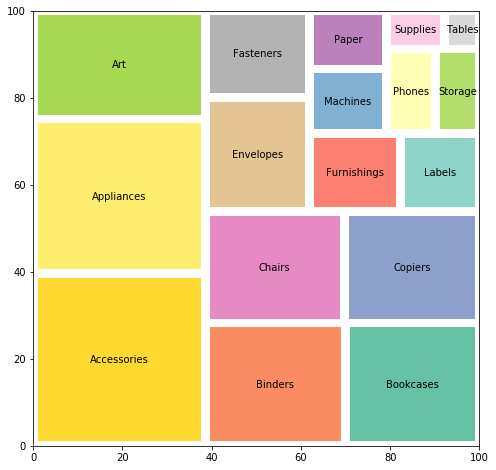

In [117]:
plt.figure(figsize=(8,8))
plot(values, norm_x=width, norm_y=height, pad=True, label=data_groupped.index, cmaps=['Set2', 'Set3'])
plt.show()